### Import Dependencies

In [1]:
from pydantic import BaseModel, Field

from langgraph.graph import StateGraph, START, END
from langgraph.prebuilt import ToolNode

from langchain_core.messages import AIMessage, ToolMessage
from langchain_core.messages import convert_to_openai_messages

from jinja2 import Template
from typing import Literal, Dict, Any, Annotated, List
from IPython.display import Image, display
from operator import add
from openai import OpenAI

import random
import ast
import inspect
import instructor
import json

from utils.utils import get_tool_descriptions, format_ai_message 

### Single Node Graph

In [2]:
class State(BaseModel): 
    message: str 
    answer: str = "" 
    vibe: str 

In [ ]:
def append_vibes_query(state: State) -> dict: 
    return{
        "answer": f"{state.message} {state.vibe}"
    }

In [4]:
workflow = StateGraph(State) 

workflow.add_node("append_vibes_query", append_vibes_query) 

workflow.add_edge(START, "append_vibes_query") 
workflow.add_edge("append_vibes_query", END) 

graph = workflow.compile() 

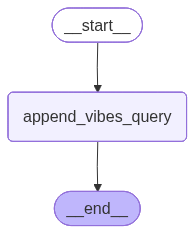

In [5]:
display(Image(graph.get_graph().draw_mermaid_png())) 

In [6]:
initial_state = {
    "message": "Give me some vibes!", 
    "vibe": "I'm feeling like a badass today!"
}

In [7]:
result = graph.invoke(initial_state) 

In [8]:
result

{'message': 'Give me some vibes!',
 'answer': "Give me some vibes! I'm feeling like a badass today!",
 'vibe': "I'm feeling like a badass today!"}

#### Conditional Graph

In [9]:
class State(BaseModel): 
    message: str 
    answer: str = "" 

In [19]:
def append_vibes_to_query(state: State) -> dict: 

    return{
        "answer": "I'm here to add some vibes:" 
    }

In [11]:
def router(state: State) -> Literal["append_vibe_1", "append_vibe_2", "append_vibe_3"]: 

    vibes = ["append_vibe_1", "append_vibe_2", "append_vibe_3"] 

    vibe_path = random.choice(vibes)  

    return vibe_path 

In [12]:
def append_vibe_1(state: State) -> dict: 

    vibe = "I'm feeling like a badass today!" 

    return{
        "answer": f"{state.answer} {state.message} {vibe}" 
    } 

def append_vibe_2(state: State) -> dict: 

    vibe = "I'm feeling like a boss today!" 

    return{
        "answer": f"{state.answer} {state.message} {vibe}" 
    } 

def append_vibe_3(state: State) -> dict: 

    vibe = "I'm feeling like a legend today!" 

    return{
        "answer": f"{state.answer} {state.message} {vibe}" 
    } 
        

In [20]:
workflow = StateGraph(State) 

workflow.add_node("append_vibes_to_query", append_vibes_to_query) 
workflow.add_node("append_vibe_1", append_vibe_1) 
workflow.add_node("append_vibe_2", append_vibe_2) 
workflow.add_node("append_vibe_3", append_vibe_3) 

workflow.add_edge(START, "append_vibes_to_query")

workflow.add_conditional_edges( 
    "append_vibes_to_query", 
    router, 
) 

workflow.add_edge("append_vibe_1", END) 
workflow.add_edge("append_vibe_2", END) 
workflow.add_edge("append_vibe_3", END) 

graph = workflow.compile() 

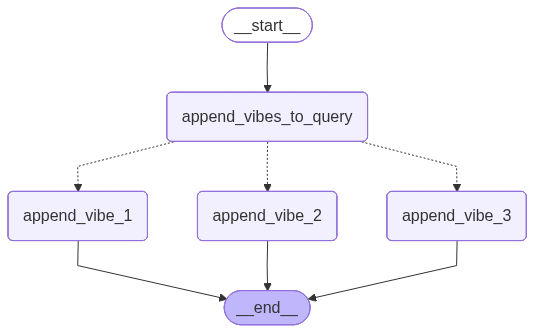

In [21]:
display(Image(graph.get_graph().draw_mermaid_png())) 

In [24]:
result = graph.invoke(initial_state) 

In [25]:
result

{'message': 'Give me some vibes!',
 'answer': "I'm here to add some vibes: Give me some vibes! I'm feeling like a legend today!"}

### Agent Graph

In [26]:
def append_vibes(query: str, vibe: str) -> str:
    """Takes in a query and a vibe and returns a string with the query and vibe appended.

    Args:
        query: The query to append the vibe to.
        vibe: The vibe to append to the query.

    Returns:
        A string with the query and vibe appended.
    """
    
    return f"{query} {vibe}"

In [31]:
get_tool_descriptions([append_vibes])

[{'name': 'append_vibes',
  'description': 'Takes in a query and a vibe and returns a string with the query and vibe appended.',
  'parameters': {'type': 'object',
   'properties': {'query': {'type': 'string',
     'description': 'The query to append the vibe to.'},
    'vibe': {'type': 'string',
     'description': 'The vibe to append to the query.'}}},
  'required': ['query', 'vibe'],
  'returns': {'type': 'string',
   'description': 'A string with the query and vibe appended.'}}]

In [33]:
class ToolCall(BaseModel):
    name: str
    arguments: dict

class AgentResponse(BaseModel):
    answer: str
    tool_calls: List[ToolCall] = Field(default_factory=list)

class State(BaseModel):
    messages: Annotated[List[Any], add] = []
    message: str = ""
    iteration: int = 0
    answer: str = ""
    available_tools: List[Dict[str, Any]] = []
    tool_calls: List[ToolCall] = []

In [ ]:
def agent_node(state: State) -> dict:

   prompt_template =  """You are a assistant that is generating vibes for a user.

You will be given a selection of tools you can use to add vibes to a user's query.

<Available tools>
{{ available_tools | tojson }}
</Available tools>

When you need to use a tool, format your response as:

<tool_call>
{"name": "tool_name", "arguments": {...}}
</tool_call>

Instructions:
- You need to use the tools to add vibes to the user's query.
- Add a random vibe to the user's query.
"""

   template = Template(prompt_template)
   
   prompt = template.render(
      available_tools=state.available_tools
   )

   client = instructor.from_openai(OpenAI())

   response, raw_response = client.chat.completions.create_with_completion(
        model="gpt-4.1-mini",
        response_model=AgentResponse,
        messages=[{"role": "system", "content": prompt}, {"role": "user", "content": state.message}],
        temperature=0.8,
   )

   ai_message = format_ai_message(response)

   return {
      "messages": [ai_message],
      "tool_calls": response.tool_calls
   }

In [ ]:
def tool_router(state: State) -> str:
    """Decide whether to continue or end"""
    
    if len(state.tool_calls) > 0:
        return "tools"
    else:
        return "end"

In [39]:
workflow = StateGraph(State) 

tools = [append_vibes]   
tool_node = ToolNode(tools) 
tool_descriptions = get_tool_descriptions(tools) 

workflow.add_node("agent_node", agent_node)
workflow.add_node("tool_node", tool_node)

workflow.add_edge(START, "agent_node")
workflow.add_conditional_edges(
    "agent_node",
    tool_router,
    {
        "tools": "tool_node",
        "end": END
    }
)
workflow.add_edge("tool_node", END)

graph = workflow.compile()

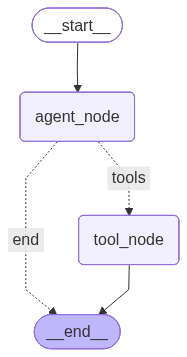

In [40]:
display(Image(graph.get_graph().draw_mermaid_png())) 

In [57]:
initial_state = {
    "message": "Give me some vibes!",
    "available_tools": tool_descriptions
}
result = graph.invoke(initial_state)

In [58]:
result

{'messages': [AIMessage(content="Sure! Here's a vibe for you.", additional_kwargs={}, response_metadata={}, tool_calls=[{'name': 'append_vibes', 'args': {'query': 'Give me some vibes!', 'vibe': 'chill and positive'}, 'id': 'call_0', 'type': 'tool_call'}]),
  ToolMessage(content='Give me some vibes! chill and positive', name='append_vibes', tool_call_id='call_0')],
 'message': 'Give me some vibes!',
 'available_tools': [{'name': 'append_vibes',
   'description': 'Takes in a query and a vibe and returns a string with the query and vibe appended.',
   'parameters': {'type': 'object',
    'properties': {'query': {'type': 'string',
      'description': 'The query to append the vibe to.'},
     'vibe': {'type': 'string',
      'description': 'The vibe to append to the query.'}}},
   'required': ['query', 'vibe'],
   'returns': {'type': 'string',
    'description': 'A string with the query and vibe appended.'}}],
 'tool_calls': [ToolCall(name='append_vibes', arguments={'query': 'Give me some 

### Agent Graph with Loopback from Tools

In [2]:
def append_vibes(query: str, vibe: str) -> str:
    """Takes in a query and a vibe and returns a string with the query and vibe appended.

    Args:
        query: The query to append the vibe to.
        vibe: The vibe to append to the query.

    Returns:
        A string with the query and vibe appended.
    """
    
    return f"{query} {vibe}"

In [3]:
class ToolCall(BaseModel):
    name: str
    arguments: dict

class AgentResponse(BaseModel):
    answer: str
    tool_calls: List[ToolCall] = Field(default_factory=list)

class State(BaseModel):
    messages: Annotated[List[Any], add] = []
    message: str = ""
    iteration: int = 0
    answer: str = ""
    available_tools: List[Dict[str, Any]] = []
    tool_calls: List[ToolCall] = []

In [24]:
def agent_node(state: State) -> dict:

   prompt_template =  """You are a assistant that is generating vibes for a user.

You will be given a selection of tools you can use to add vibes to a user's query.

<Available tools>
{{ available_tools | tojson }}
</Available tools>

When you need to use a tool, format your response as:

<tool_call>
{"name": "tool_name", "arguments": {...}}
</tool_call>

Instructions:
- You need to use the tools to add vibes to the user's query.
- Add a random vibe to the user's query.
- You must return a tool call in the first interaction. 
"""

   template = Template(prompt_template)
   
   prompt = template.render(
      available_tools=state.available_tools
   )

   messages = state.messages 

   conversation = convert_to_openai_messages(messages)

   client = instructor.from_openai(OpenAI())

   response, raw_response = client.chat.completions.create_with_completion(
        model="gpt-4.1-mini",
        response_model=AgentResponse,
        messages=[{"role": "system", "content": prompt}, *conversation],
        temperature=0.8,
   )

   ai_message = format_ai_message(response)

   return {
      "messages": [ai_message],
      "tool_calls": response.tool_calls,
      "iteration": state.iteration + 1,
      "answer": response.answer
   }

In [25]:
def tool_router(state: State) -> str:
    """Decide whether to continue or end"""
    
    if state.iteration > 1: 
        return "end"
    elif len(state.tool_calls) > 0:
        return "tools"
    else:
        return "end"

In [26]:
workflow = StateGraph(State)

tools = [append_vibes]
tool_node = ToolNode(tools)
tool_descriptions = get_tool_descriptions(tools)

workflow.add_node("agent_node", agent_node)
workflow.add_node("tool_node", tool_node)

workflow.add_edge(START, "agent_node")
workflow.add_conditional_edges(
    "agent_node",
    tool_router,
    {
        "tools": "tool_node",
        "end": END
    }
)

workflow.add_edge("tool_node", "agent_node")

graph = workflow.compile()

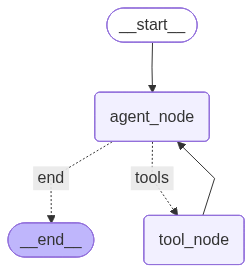

In [27]:
display(Image(graph.get_graph().draw_mermaid_png())) 

In [28]:
initial_state = {
    "messages": [{"role": "user", "content": "Give me some vibes!"}],
    "available_tools": tool_descriptions
}
result = graph.invoke(initial_state)

In [29]:
result

{'messages': [{'role': 'user', 'content': 'Give me some vibes!'},
  AIMessage(content='', additional_kwargs={}, response_metadata={}, tool_calls=[{'name': 'append_vibes', 'args': {'query': 'Give me some vibes!', 'vibe': 'chill and uplifting'}, 'id': 'call_0', 'type': 'tool_call'}]),
  ToolMessage(content='Give me some vibes! chill and uplifting', name='append_vibes', tool_call_id='call_0'),
  AIMessage(content='Give me some vibes! chill and uplifting', additional_kwargs={}, response_metadata={}, tool_calls=[{'name': 'append_vibes', 'args': {'query': 'Give me some vibes!', 'vibe': 'chill and uplifting'}, 'id': 'call_0', 'type': 'tool_call'}])],
 'iteration': 2,
 'answer': 'Give me some vibes! chill and uplifting',
 'available_tools': [{'name': 'append_vibes',
   'description': 'Takes in a query and a vibe and returns a string with the query and vibe appended.',
   'parameters': {'type': 'object',
    'properties': {'query': {'type': 'string',
      'description': 'The query to append th